In [34]:
import pandas as pd
from sympy import *
from sympy.physics.mechanics import *
import matplotlib.pyplot as plt
from sympy import Symbol, Derivative
import itertools
import math
import operator as op
from functools import reduce
import numpy as np
import scipy


def tuple_combinations(m,n):

    # maximum power of any coordinate or velocity to be m
    # maximum degree of any combination of coordinates and velocities to n
    
    list_m=list(range(2,m+1))
    list_n=list(range(2,n+1))
    
    list1=list(itertools.product(list_m,list_n))
    
    return list1

def power_tuple(m,n):
    
    i = 0    
    em = []
    while i <= m:        
        j = 0
        while i+j <=n and j <=m:
            em.append((i,j))
            j =j+1
        i = i+1
    em.remove((0,0))
    
    for tup in em:
        if tup[1]==1:
            em.remove(tup)
    
    em.append((0,1))
    
    return em

def U(x):
    return log((x+10**(-10))**2)+1

def create_coefficient_lists(m,n,list_of_variables):
    
    #This function computes the number of terms in the polynomial 
    #given the number m and n and returns a list of coefficients
    #𝑚=max power of each coefficient
    #𝑛=max sum of the power of the coefficients    
    value=len(power_tuple(m,n))
    
    #List of coeffiecinets generated using sympy to enable further manupulation
    list_of_coefficinets=[Symbol("C_"+str(i)) for i in range(int(value))]
        
    return list_of_coefficinets

def trial(m,n,list_of_variables=[dynamicsymbols("theta"),dynamicsymbols("theta",1),dynamicsymbols("theta",2)]):


    #This Function returns the cost function evaluated 
    # from the Lagrangian depending on the parameters
    
    Coef_list=create_coefficient_lists(m,n,list_of_variables)

    tuple_of_lagrangians_power=tuple_combinations(m,n)

    list_of_possible_L=[]
    list_of_cf=[]

    for tup in tuple_of_lagrangians_power:

        a=power_tuple(tup[0],tup[1])
        
        L=0
        k=0

        for i in a:
            L+=Coef_list[k]*(list_of_variables[0]**i[0])*(list_of_variables[1]**i[1])
            k+=1
        list_of_possible_L.append(L)
    
    final=[]
    
    for lagrangian in list_of_possible_L:
        El = (diff(diff(lagrangian, list_of_variables[1]), 't') - diff(lagrangian, list_of_variables[0]))**2
        Nd= (diff(diff(lagrangian, list_of_variables[1]), 't'))**2 + (diff(lagrangian, list_of_variables[0]))**2
        final.append((El,Nd,lagrangian))
    return (final,Coef_list)

def trial2(m,n,list_of_variables=[dynamicsymbols("theta"),dynamicsymbols("theta",1),dynamicsymbols("theta",2)]):

    #This Function returns the cost function evaluated from the Lagrangian depending on the parameters
    
    #Creates a list of coefficients [C_0,_C1,...,etc]
    Coef_list=create_coefficient_lists(m,n,list_of_variables)
        
    a=power_tuple(m,n)

    #Initialise the lagrangian     
    lagrangian=0
    k=0

    #Using the above we find the lagrangian
    for i in a:
        lagrangian+=Coef_list[k]*(list_of_variables[0]**i[0])*(list_of_variables[1]**i[1])
        k+=1
        
    final=[]
    
    #The components of the cost function. Refer Hills paper for more details. 
    El = (diff(diff(lagrangian, list_of_variables[1]), 't') - diff(lagrangian, list_of_variables[0]))**2
    Nd= (diff(diff(lagrangian, list_of_variables[1]), 't'))**2 + (diff(lagrangian, list_of_variables[0]))**2
    
    final.append((El,Nd))
    
    return (final,Coef_list)

def optimizer(m,n,real_data,control_data,list_of_variables):
    #This function computes the numerical value of the cost function over the data 
    EL_d=0
    EL_c=0
    Nd=0

    pos=real_data[:,0]
    vel=real_data[:,1]
    acc=real_data[:,2]
    
    pos_c=control_data[:,0]
    vel_c=control_data[:,1]
    acc_c=control_data[:,2]
    

    #Current tuple of Cost function components based on m and n
    x=trial2(m,n,list_of_variables)[0][0]
    
    

    for i in range(len(real_data)):

        #Fit the real data for EL_d & Nd
        EL_d+=x[0].subs({list_of_variables[0]:pos[i],list_of_variables[1]:vel[i],list_of_variables[2]:acc[i]})
        Nd+=x[1].subs({list_of_variables[0]:pos[i],list_of_variables[1]:vel[i],list_of_variables[2]:acc[i]})
    
    for i in range(len(control_data)):
        #Fit the control data for EL_c
        #Control data and EL_c exists to avoid unwated terms in the lagrangians
        EL_c+=x[0].subs({list_of_variables[0]:pos_c[i],list_of_variables[1]:vel_c[i],list_of_variables[2]:acc_c[i]})

    #Final cost function
    fun=(U(EL_c)*U(Nd)*(EL_d+10**(-10))/(EL_c+10**(-10)))

    tup_of_free_symbols=tuple("C_"+str(i) for i in range(len(fun.free_symbols)))

    fun2 = lambdify(tup_of_free_symbols,fun)

    #Constraint Tuple
    bnds=tuple((-1,1) for i in range(len(fun.free_symbols)))
    
    #Tuple of initial values
    initial_value=tuple(1 for i in range(len(fun.free_symbols)))

    fun3 = lambda x: fun2(*x) # Unpack tuple into positional args
    return scipy.optimize.minimize(fun3, x0=initial_value, method="TNC",bounds=bnds,tol=1e-7)

   
def main(real_data,control_data,list_of_variables):
    #This function iterates through the possible combinations of poynomial power till convergence is achieved
    m=2
    n=2
    i=0
    f_or_s=False
    
    #Checks various possible combinations of the lagrangians. Increases m and n one at a time. 
    while f_or_s==False:
        
        if i%2==0:
            
            result=optimizer(m,n,real_data,control_data,list_of_variables)
            
            lag_tup=(m,n)
            
            f_or_s=result.success
            
            m+=1
        
        else:
            
            result=optimizer(m,n,real_data,control_data,list_of_variables)

            f_or_s=result.success
            
            lag_tup=(m,n)
            
            n+=1
            
        i+=1
    
    return result.x,lag_tup

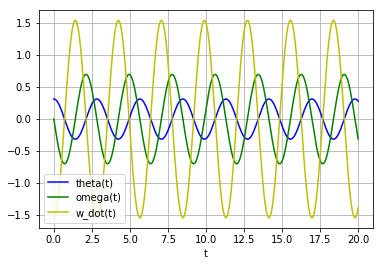

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.integrate import odeint

def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0
c = 5.0
y0 = [0.314, 0]
t = np.linspace(0, 20, 301)

sol = odeint(pend, y0, t, args=(b, c))

pos=sol[:,0]
vel=sol[:,1]
acc=[-1*c*np.sin(i) for i in pos]

plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1],
         
         
         
         
         
         
         
         
         
         'g', label='omega(t)')
plt.plot(t,acc,"y",label='w_dot(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

In [36]:
control_data=np.array([[0.0, 0.1, 0],
 [0.006666666666666667, 0.1, 0],
 [0.013333333333333334, 0.1, 0],
 [0.020000000000000004, 0.1, 0],
 [0.02666666666666667, 0.1, 0],
 [0.03333333333333333, 0.1, 0],
 [0.04000000000000001, 0.1, 0],
 [0.04666666666666667, 0.1, 0],
 [0.05333333333333334, 0.1, 0],
 [0.06, 0.1, 0],
 [0.06666666666666667, 0.1, 0],
 [0.07333333333333333, 0.1, 0],
 [0.08000000000000002, 0.1, 0],
 [0.08666666666666667, 0.1, 0],
 [0.09333333333333334, 0.1, 0],
 [0.1, 0.1, 0],
 [0.10666666666666667, 0.1, 0],
 [0.11333333333333334, 0.1, 0],
 [0.12, 0.1, 0],
 [0.12666666666666668, 0.1, 0],
 [0.13333333333333333, 0.1, 0],
 [0.13999999999999999, 0.1, 0],
 [0.14666666666666667, 0.1, 0],
 [0.15333333333333332, 0.1, 0],
 [0.16000000000000003, 0.1, 0],
 [0.16666666666666669, 0.1, 0],
 [0.17333333333333334, 0.1, 0],
 [0.18000000000000002, 0.1, 0],
 [0.18666666666666668, 0.1, 0],
 [0.19333333333333336, 0.1, 0],
 [0.2, 0.1, 0],
 [0.20666666666666667, 0.1, 0],
 [0.21333333333333335, 0.1, 0],
 [0.22000000000000003, 0.1, 0],
 [0.22666666666666668, 0.1, 0],
 [0.23333333333333336, 0.1, 0],
 [0.24, 0.1, 0],
 [0.2466666666666667, 0.1, 0],
 [0.25333333333333335, 0.1, 0],
 [0.26, 0.1, 0],
 [0.26666666666666666, 0.1, 0],
 [0.2733333333333334, 0.1, 0],
 [0.27999999999999997, 0.1, 0],
 [0.2866666666666667, 0.1, 0],
 [0.29333333333333333, 0.1, 0],
 [0.30000000000000004, 0.1, 0],
 [0.30666666666666664, 0.1, 0],
 [0.31333333333333335, 0.1, 0],
 [0.32000000000000006, 0.1, 0],
 [0.32666666666666666, 0.1, 0],
 [0.33333333333333337, 0.1, 0],
 [0.34, 0.1, 0],
 [0.3466666666666667, 0.1, 0],
 [0.35333333333333333, 0.1, 0],
 [0.36000000000000004, 0.1, 0],
 [0.3666666666666667, 0.1, 0],
 [0.37333333333333335, 0.1, 0],
 [0.38, 0.1, 0],
 [0.3866666666666667, 0.1, 0],
 [0.3933333333333333, 0.1, 0],
 [0.4, 0.1, 0],
 [0.4066666666666667, 0.1, 0],
 [0.41333333333333333, 0.1, 0],
 [0.42000000000000004, 0.1, 0],
 [0.4266666666666667, 0.1, 0],
 [0.43333333333333335, 0.1, 0],
 [0.44000000000000006, 0.1, 0],
 [0.4466666666666667, 0.1, 0],
 [0.45333333333333337, 0.1, 0],
 [0.45999999999999996, 0.1, 0],
 [0.46666666666666673, 0.1, 0],
 [0.4733333333333334, 0.1, 0],
 [0.48, 0.1, 0],
 [0.48666666666666664, 0.1, 0],
 [0.4933333333333334, 0.1, 0],
 [0.5, 0.1, 0],
 [0.5066666666666667, 0.1, 0],
 [0.5133333333333333, 0.1, 0],
 [0.52, 0.1, 0],
 [0.5266666666666667, 0.1, 0],
 [0.5333333333333333, 0.1, 0],
 [0.54, 0.1, 0],
 [0.5466666666666667, 0.1, 0],
 [0.5533333333333333, 0.1, 0],
 [0.5599999999999999, 0.1, 0],
 [0.5666666666666668, 0.1, 0],
 [0.5733333333333334, 0.1, 0],
 [0.58, 0.1, 0],
 [0.5866666666666667, 0.1, 0],
 [0.5933333333333334, 0.1, 0],
 [0.6000000000000001, 0.1, 0],
 [0.6066666666666667, 0.1, 0],
 [0.6133333333333333, 0.1, 0],
 [0.6200000000000001, 0.1, 0],
 [0.6266666666666667, 0.1, 0],
 [0.6333333333333333, 0.1, 0],
 [0.6400000000000001, 0.1, 0],
 [0.6466666666666667, 0.1, 0],
 [0.6533333333333333, 0.1, 0],
 [0.66, 0.1, 0],
 [0.6666666666666667, 0.1, 0],
 [0.6733333333333333, 0.1, 0],
 [0.68, 0.1, 0],
 [0.6866666666666666, 0.1, 0],
 [0.6933333333333334, 0.1, 0],
 [0.7000000000000001, 0.1, 0],
 [0.7066666666666667, 0.1, 0],
 [0.7133333333333334, 0.1, 0],
 [0.7200000000000001, 0.1, 0],
 [0.7266666666666667, 0.1, 0],
 [0.7333333333333334, 0.1, 0],
 [0.74, 0.1, 0],
 [0.7466666666666667, 0.1, 0],
 [0.7533333333333334, 0.1, 0],
 [0.76, 0.1, 0],
 [0.7666666666666667, 0.1, 0],
 [0.7733333333333334, 0.1, 0],
 [0.78, 0.1, 0],
 [0.7866666666666666, 0.1, 0],
 [0.7933333333333334, 0.1, 0],
 [0.8, 0.1, 0],
 [0.8066666666666666, 0.1, 0],
 [0.8133333333333334, 0.1, 0],
 [0.82, 0.1, 0],
 [0.8266666666666667, 0.1, 0],
 [0.8333333333333335, 0.1, 0],
 [0.8400000000000001, 0.1, 0],
 [0.8466666666666667, 0.1, 0],
 [0.8533333333333334, 0.1, 0],
 [0.86, 0.1, 0],
 [0.8666666666666667, 0.1, 0],
 [0.8733333333333333, 0.1, 0],
 [0.8800000000000001, 0.1, 0],
 [0.8866666666666667, 0.1, 0],
 [0.8933333333333334, 0.1, 0],
 [0.9, 0.1, 0],
 [0.9066666666666667, 0.1, 0],
 [0.9133333333333333, 0.1, 0],
 [0.9199999999999999, 0.1, 0],
 [0.9266666666666666, 0.1, 0],
 [0.9333333333333335, 0.1, 0],
 [0.9400000000000001, 0.1, 0],
 [0.9466666666666668, 0.1, 0],
 [0.9533333333333334, 0.1, 0],
 [0.96, 0.1, 0],
 [0.9666666666666667, 0.1, 0],
 [0.9733333333333333, 0.1, 0],
 [0.9800000000000001, 0.1, 0],
 [0.9866666666666668, 0.1, 0],
 [0.9933333333333334, 0.1, 0],
 [1.0, 0.1, 0],
 [1.0066666666666666, 0.1, 0],
 [1.0133333333333334, 0.1, 0],
 [1.02, 0.1, 0],
 [1.0266666666666666, 0.1, 0],
 [1.0333333333333334, 0.1, 0],
 [1.04, 0.1, 0],
 [1.0466666666666666, 0.1, 0],
 [1.0533333333333335, 0.1, 0],
 [1.06, 0.1, 0],
 [1.0666666666666667, 0.1, 0],
 [1.0733333333333333, 0.1, 0],
 [1.08, 0.1, 0],
 [1.0866666666666667, 0.1, 0],
 [1.0933333333333335, 0.1, 0],
 [1.1, 0.1, 0],
 [1.1066666666666667, 0.1, 0],
 [1.1133333333333333, 0.1, 0],
 [1.1199999999999999, 0.1, 0],
 [1.1266666666666667, 0.1, 0],
 [1.1333333333333335, 0.1, 0],
 [1.1400000000000001, 0.1, 0],
 [1.1466666666666667, 0.1, 0],
 [1.1533333333333333, 0.1, 0],
 [1.16, 0.1, 0],
 [1.1666666666666667, 0.1, 0],
 [1.1733333333333333, 0.1, 0],
 [1.1800000000000002, 0.1, 0],
 [1.1866666666666668, 0.1, 0],
 [1.1933333333333334, 0.1, 0],
 [1.2000000000000002, 0.1, 0],
 [1.2066666666666668, 0.1, 0],
 [1.2133333333333334, 0.1, 0],
 [1.22, 0.1, 0],
 [1.2266666666666666, 0.1, 0],
 [1.2333333333333334, 0.1, 0],
 [1.2400000000000002, 0.1, 0],
 [1.2466666666666668, 0.1, 0],
 [1.2533333333333334, 0.1, 0],
 [1.26, 0.1, 0],
 [1.2666666666666666, 0.1, 0],
 [1.2733333333333334, 0.1, 0],
 [1.2800000000000002, 0.1, 0],
 [1.2866666666666668, 0.1, 0],
 [1.2933333333333334, 0.1, 0],
 [1.3, 0.1, 0],
 [1.3066666666666666, 0.1, 0],
 [1.3133333333333335, 0.1, 0],
 [1.32, 0.1, 0],
 [1.3266666666666667, 0.1, 0],
 [1.3333333333333335, 0.1, 0],
 [1.34, 0.1, 0],
 [1.3466666666666667, 0.1, 0],
 [1.3533333333333335, 0.1, 0],
 [1.36, 0.1, 0],
 [1.3666666666666667, 0.1, 0],
 [1.3733333333333333, 0.1, 0],
 [1.38, 0.1, 0],
 [1.3866666666666667, 0.1, 0],
 [1.3933333333333335, 0.1, 0],
 [1.4000000000000001, 0.1, 0],
 [1.4066666666666667, 0.1, 0],
 [1.4133333333333333, 0.1, 0],
 [1.42, 0.1, 0],
 [1.4266666666666667, 0.1, 0],
 [1.4333333333333336, 0.1, 0],
 [1.4400000000000002, 0.1, 0],
 [1.4466666666666668, 0.1, 0],
 [1.4533333333333334, 0.1, 0],
 [1.46, 0.1, 0],
 [1.4666666666666668, 0.1, 0],
 [1.4733333333333334, 0.1, 0],
 [1.48, 0.1, 0],
 [1.4866666666666668, 0.1, 0],
 [1.4933333333333334, 0.1, 0],
 [1.5, 0.1, 0],
 [1.5066666666666668, 0.1, 0],
 [1.5133333333333334, 0.1, 0],
 [1.52, 0.1, 0],
 [1.5266666666666666, 0.1, 0],
 [1.5333333333333334, 0.1, 0],
 [1.54, 0.1, 0],
 [1.5466666666666669, 0.1, 0],
 [1.5533333333333335, 0.1, 0],
 [1.56, 0.1, 0],
 [1.5666666666666667, 0.1, 0],
 [1.5733333333333333, 0.1, 0],
 [1.58, 0.1, 0],
 [1.586666666666667, 0.1, 0],
 [1.5933333333333335, 0.1, 0],
 [1.6, 0.1, 0],
 [1.6066666666666667, 0.1, 0],
 [1.6133333333333333, 0.1, 0],
 [1.62, 0.1, 0],
 [1.6266666666666667, 0.1, 0],
 [1.6333333333333333, 0.1, 0],
 [1.64, 0.1, 0],
 [1.6466666666666665, 0.1, 0],
 [1.6533333333333333, 0.1, 0],
 [1.6600000000000001, 0.1, 0],
 [1.666666666666667, 0.1, 0],
 [1.6733333333333336, 0.1, 0],
 [1.6800000000000002, 0.1, 0],
 [1.6866666666666668, 0.1, 0],
 [1.6933333333333334, 0.1, 0],
 [1.7000000000000002, 0.1, 0],
 [1.7066666666666668, 0.1, 0],
 [1.7133333333333334, 0.1, 0],
 [1.72, 0.1, 0],
 [1.7266666666666666, 0.1, 0],
 [1.7333333333333334, 0.1, 0],
 [1.74, 0.1, 0],
 [1.7466666666666666, 0.1, 0],
 [1.7533333333333332, 0.1, 0],
 [1.7600000000000002, 0.1, 0],
 [1.7666666666666668, 0.1, 0],
 [1.7733333333333334, 0.1, 0],
 [1.7800000000000002, 0.1, 0],
 [1.7866666666666668, 0.1, 0],
 [1.7933333333333334, 0.1, 0],
 [1.8, 0.1, 0],
 [1.8066666666666666, 0.1, 0],
 [1.8133333333333335, 0.1, 0],
 [1.82, 0.1, 0],
 [1.8266666666666667, 0.1, 0],
 [1.8333333333333333, 0.1, 0],
 [1.8399999999999999, 0.1, 0],
 [1.8466666666666667, 0.1, 0],
 [1.8533333333333333, 0.1, 0],
 [1.8600000000000003, 0.1, 0],
 [1.866666666666667, 0.1, 0],
 [1.8733333333333335, 0.1, 0],
 [1.8800000000000001, 0.1, 0],
 [1.8866666666666667, 0.1, 0],
 [1.8933333333333335, 0.1, 0],
 [1.9000000000000001, 0.1, 0],
 [1.9066666666666667, 0.1, 0],
 [1.9133333333333333, 0.1, 0],
 [1.92, 0.1, 0],
 [1.9266666666666667, 0.1, 0],
 [1.9333333333333333, 0.1, 0],
 [1.94, 0.1, 0],
 [1.9466666666666665, 0.1, 0],
 [1.9533333333333331, 0.1, 0],
 [1.9600000000000002, 0.1, 0],
 [1.9666666666666668, 0.1, 0],
 [1.9733333333333336, 0.1, 0],
 [1.9800000000000002, 0.1, 0],
 [1.9866666666666668, 0.1, 0],
 [1.9933333333333334, 0.1, 0],
 [2.0, 0.1, 0]])


In [37]:
real_data=np.array([list(a) for a in zip(pos,vel,acc)])

## The following is the final result.
## It shows the coefficients of the lagrangian([C_4,C_0,C_1]) and the m and n values. 
$$L=C_0\theta+C_1\dot{\theta^2}+C_2\theta \dot{\theta}+C_3\dot{\theta}+C_4\dot{\theta}^2$$

Euler-Lagrange equation

$$2C_4 \ddot{\theta}=C_0+2C_1\theta$$

The coefficients which cancel out are not included in the optimization. The way I handled this is to optimize after finding the free symbols in the cost function(hence the other coefficients are not included).


In [38]:
main(real_data,control_data,list_of_variables=[dynamicsymbols("theta"),dynamicsymbols("theta",1),dynamicsymbols("theta",2)])

(array([-2.02493646e-01, -2.23804363e-05,  9.99970400e-01]), (2, 2))